# Recommender System 

## KNN and Collaborative Filtering

In this project, I will build an item-based collaborative filtering system using Users datasets. 
Specically, I will train a KNN models to cluster similar users based on user's ratings and make user recommendation based on similarity score of previous rated profiles.

## Recommender system
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use item-based collaborative filtering systems make users recommendation. In other words, the _things to be recommended_ are the users themselves.

### Item-based Collaborative Filtering
Collaborative filtering based systems use the actions of users to recommend other items. In general, they can either be user based or item based. User based collaborating filtering uses the patterns of users similar to me to recommend a product (users like me also looked at these other items). Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items). Item-based approach is usually prefered than user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don't change much, so item-based approach often can be computed offline.

### Project Content
1. Load data
2. Exploratory data analysis
3. Train KNN model for item-based collaborative filtering
4. Use this trained model to make movie recommendations to myself
5. Deep dive into the bottleneck of item-based collaborative filtering.
     * cold start problem
     * data sparsity problem
     * popular bias (how to recommend products from the tail of product distribution)
     * scalability bottleneck
6. Further study

### Dataset

We can take into account data spread in two dataframes:
1. Users features (user id, features);
2. Users matches (user1, user2, match).

The first one is used to calculate similarities between users, while the second one will be useful to train the model and predict new ratings.

We make use of dataset from co-working space company.

Files contain $18\,646$ rows corresponding to anonymous ratings of $2\,044$ profiles made by $1\,848$ users.

## Load Data

In [1]:
# Import libraries

import os
import time

import math
import re
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, Normalizer

from fuzzywuzzy import fuzz

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
DATA_PATH = 'data/'

profiles = DATA_PATH + 'users_model_customers.json'
matches = DATA_PATH + 'training_match.json'

In [3]:
# Load data
df_users = pd.read_json(profiles, lines=True, orient='values')

df_matches = pd.read_json(matches, lines=True, orient='values')

In [4]:
df_users.head()

,wetipp_id,email,enabled,gender,title,auth0_id,gender_merged,valid_until_to_date,valid_from_to_date,is_valid,...,cus_linkedin_url,cus_name,cus_number_of_employees,cus_product_service,cus_twitter_url,cus_value_chain_position,cus_venture_capital_investor_stages,cus_website,cus_category_vect,cus_industry_vect
0,4124,a.albertoprezioso@gmail.com,1,m,Consultant,auth0|5a5f30c429c86805e5da5e85,u,1.590883e+12,1559347200000,True,...,https://www.linkedin.com/in/albertoprezioso/,Alberto Prezioso,2 - 4 Employees,Consulting/Agency Service,None,Service Provider (We support with expertise an...,€0 (We don't invest Venture Capital),https://www.linkedin.com/in/albertoprezioso/,"[for profit organization, consulting / freelan...","[business & productivity, consulting and resea..."
1,5569,a.aquino@dol.it,1,m,Creative Designer,auth0|5c3cc5d31b53823baa34a3e9,u,1.585613e+12,1554076800000,True,...,https://www.linkedin.com/company/1074425,Dol,20 - 50 Employees,"Digital Product/Service, Consulting/Agency Ser...",https://twitter.com/DolDigital,"Developer (We develop new products/services), ...",€0 (We don't invest Venture Capital),www.dol.it,"[for profit organization, media / communicatio...","[business & productivity, consulting and resea..."
2,9490,a.augusto@blackonyx.ie,0,u,None,auth0|5df9fc2f0949bc0ec2f4bf06,u,1.593475e+12,1561939200000,True,...,None,None,None,None,None,None,None,None,None,None
3,7825,a.bassi@backtowork24.com,1,m,CEO,auth0|5d2f40b3dacb240dd47f8034,u,NaN,1563235200000,True,...,https://wwwlinkedin.com/company/back-to-work-24,BacktoWork24,10 - 19 Employees,Consulting/Agency Service,https://twitter.com/BacktoWork24,Service Provider (We support with expertise an...,€251k - €1M (Early Stage),www.backtowork24.com,"[for profit organization, corporate / sme / st...","[finance & insurance, investing and wealth man..."
4,4674,a.bernardini@e-motion.com,1,m,chief technology officer,auth0|5b1e3bf2739fba311ba09105,u,1.598573e+12,1527811200000,True,...,https://www.linkedin.com/company/e-motion-made...,M4EC Italia SRL,10 - 19 Employees,Digital Product/Service,None,Service Provider (We support with expertise an...,€0 (We don't invest Venture Capital),www.e-motion.com,"[for profit organization, corporate / sme / st...","[business & productivity, it infrastructure an..."


In [5]:
feature_cols = [
 'branch_name',
 # 'company_category_industry', # too many null values
 # 'company_description', # too many null values
 # 'company_domain', # too many null values
 # 'company_metrics_employees_range', # too many null values
 # 'company_metrics_estimated_annual_revenue', # too many null values
 # 'company_twitter_followers', # too many null values
 # 'company_twitter_following', # too many null values
 # 'company_type', # too many null values
 # 'cus_address', # too many null values
 # 'cus_address_country', # too many null values
 # 'cus_address_google_place_id', # too many null values
 # 'cus_business_type', # too many null values
 'cus_category_vect',
 # 'cus_city', # too many null values
 # 'cus_country', # too many null values
 'cus_customer_focus',
 'cus_description',
 'cus_industry_vect',
 'interests',
 'jobs_vect',
 'main_job',
 'skills_vect',
 'title'
]

types_cols = [
 'vector_category',
 # 'category', # too many null values
 # 'text', # too many null values
 # 'category', # too many null values
 # 'category', # too many null values
 # 'numerical', # too many null values
 # 'numerical', # too many null values
 # 'numerical', # too many null values
 # 'category', # too many null values
 # 'text', # too many null values
 # 'category', # too many null values
 # 'category', # too many null values
 # 'category', # too many null values
 'vector_category',
 # 'category', # too many null values
 # 'category', # too many null values
 'category',
 'text',
 'vector_category',
 'vector_category',
 'vector_category',
 'category',
 'vector_category',
 'text'
]

In [6]:
df_matches.head()

,match_ok,_negative_reason,negative_reason,sent_to_feedback_api,final,timestamp,direction,business_expert,model_id,recommended_user_id,be_user_id__querying_user_id,querying_user_id,model_version,be_user_id,IP
0,False,no_meeting_needed,no_meeting_needed,0.0,0.0,2019-07-04T07:19:06+00:00,direct,0.0,20190703,auth0|5c814ef0a5d9e205f34bf54d,auth0|5c9251dd8493d55b61d62d57_auth0|5c814ef0a...,auth0|5c9251dd8493d55b61d62d57,NaN,NaN,NaN
1,True,NaN,NaN,0.0,0.0,2019-06-27T16:38:16+00:00,inverse,0.0,20190626,auth0|5c5b21fdeb90374251db3614,auth0|5cf6736040c0c00de7dec96d_auth0|5c5b21fde...,auth0|5cf6736040c0c00de7dec96d,NaN,NaN,NaN
2,True,NaN,NaN,0.0,0.0,2019-09-05T07:48:56+00:00,direct,0.0,20190904,auth0|5c81568ba5d9e205f34bf7a5,auth0|5cf6736040c0c00de7dec96d_auth0|5c81568ba...,auth0|5cf6736040c0c00de7dec96d,NaN,NaN,NaN
3,False,bad_fit,NaN,0.0,0.0,2019-10-31 07:38:48.970548,direct,0.0,20191030,auth0|5c8684aadf09d10bf6e1499d,auth0|5db2976b0cfca60dc2dbef3c_auth0|5c8684aad...,auth0|5db2976b0cfca60dc2dbef3c,NaN,NaN,NaN
4,True,NaN,NaN,NaN,NaN,2019-03-12 07:32:16.035178,NaN,NaN,NaN,auth0|5c47159324e8262bce7be27a,auth0|5b8d27a3cabc2d758e04137a_auth0|5be94d5b2...,auth0|5be94d5b2134bd69842d1341,ModelKNNsavedProdAuthIds26febNOTAGschool_test....,auth0|5b8d27a3cabc2d758e04137a,46.189.28.74


In [7]:
df_types = pd.DataFrame({'type': types_cols, 'variable': feature_cols})

## Exploratory Analysis

* Plot the counts of each rating
* Plot rating frequency of each user

In [8]:
num_users = len(df_users.auth0_id)

num_q = len(df_matches.querying_user_id.unique())
num_r = len(df_matches.recommended_user_id.unique())

In [9]:
df_matches['match_ok'] = df_matches.match_ok.astype(bool);

#### 1. Plot the counts of each rating

In [10]:
# get count
df_matches_cnt = pd.DataFrame(df_matches.groupby('match_ok').size(), columns=['count'])
df_matches_cnt

,count
match_ok,
False,11149
True,7497


The count for zero rating score is too big to compare with others. So a standard technique in these cases is to take log transform for count values and then plot them to compare.

In [11]:
# add log count
df_matches_cnt['log_count'] = np.log(df_matches_cnt['count'])
df_matches_cnt

,count,log_count
match_ok,,
False,11149,9.319105
True,7497,8.922258


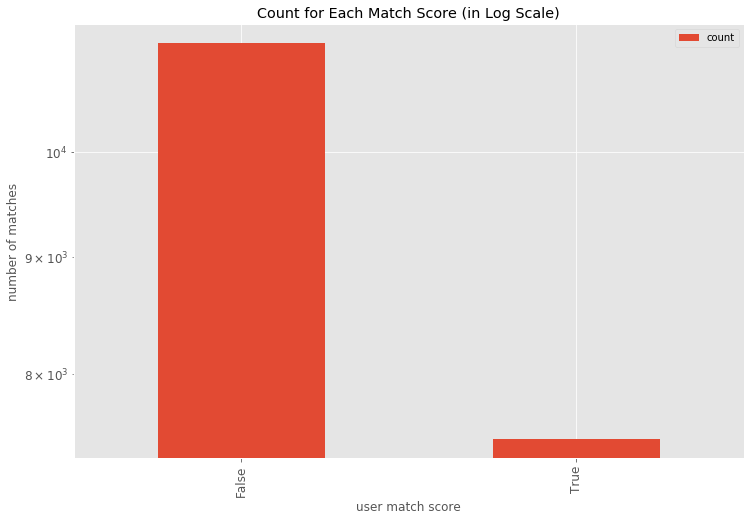

In [12]:
ax = df_matches_cnt[['count']].reset_index().rename(columns={'index': 'match score'}).plot(
    x='match_ok',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Match Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("user match score")
ax.set_ylabel("number of matches");

#### 2. Plot rating frequency of all users

In [13]:
# get rating frequency
df_profiles_cnt = pd.DataFrame(df_matches.groupby('recommended_user_id').size(), columns=['count'])
df_profiles_cnt.head()

,count
recommended_user_id,
auth0|5a376f09150063783e1feff6,4
auth0|5a376f99150063783e1ff01d,2
auth0|5a376fa522be3b22cd07a59b,30
auth0|5a3770af22be3b22cd07a5ee,25
auth0|5a377142150063783e1ff0b2,1


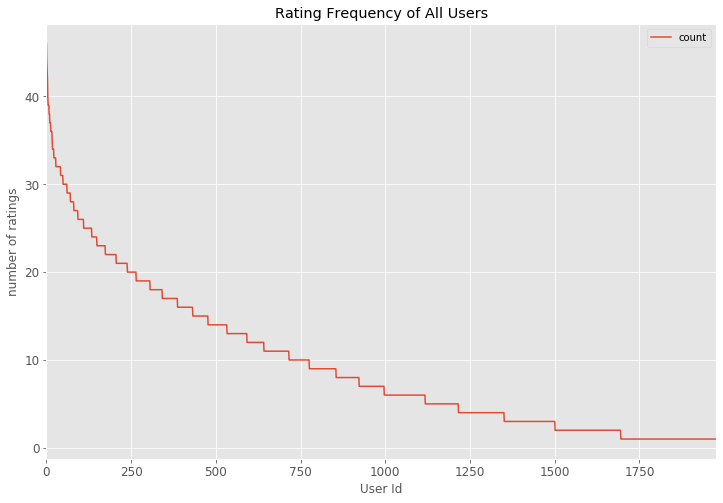

In [14]:
# plot rating frequency of all users
ax = df_profiles_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings");

The distribution of ratings among users often satisfies a property in real-world settings, which is referred to as the __long-tail property__. 
According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale.

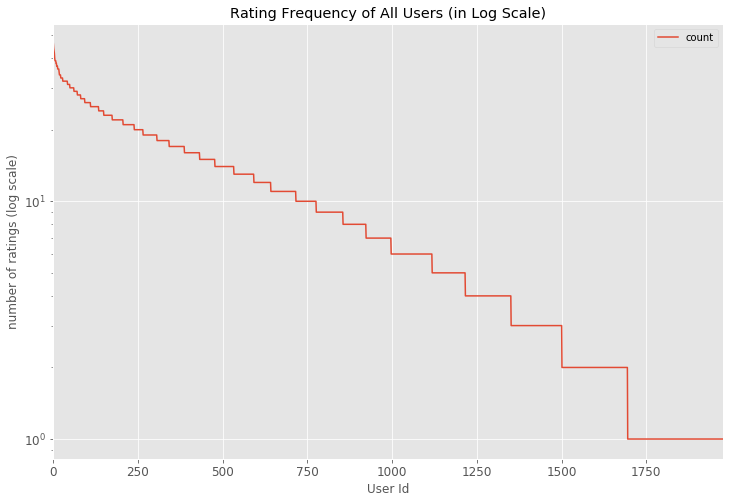

In [15]:
# plot rating frequency of all users in log scale
ax = df_profiles_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings (log scale)");

We can see that roughly $30\,000$ out of $168\,791$ users are rated more than $100$ times. More interestingly, roughly $50\,000$ out of $168\,791$ users are rated less than only $10$ times. Let's look closer by displaying top quantiles of rating counts.

In [16]:
df_profiles_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    46.0
0.95    26.0
0.90    22.0
0.85    19.0
0.80    16.0
0.75    14.0
0.70    12.0
0.65    11.0
Name: count, dtype: float64

So about $1\%$ of users have roughly $33\,389$ or more ratings, $5\%$ have $410$ or more, and $20\%$ have $104$ or more. 
Since we have so many users, we'll limit it to the top $25\%$. 
This is arbitrary threshold for popularity.
There are two reasons why we want to filter our dataset.

1. Memory issue: we don't want to run into the `MemoryError` during model training
2. Improve KNN performance: lesser known users have ratings from fewer viewers, making the pattern more noisy. Droping out less evaluated users can improve recommendation quality.

In [17]:
# filter data
popularity_thres = 10
popular_users = list(set(df_profiles_cnt.query('count >= @popularity_thres').index))
df_matches_drop_users = df_matches[df_matches.recommended_user_id.isin(popular_users)]
print('shape of original ratings data: ', df_matches.shape)
print('shape of ratings data after dropping unpopular users: ', df_matches_drop_users.shape)

shape of original ratings data:  (18646, 15)
shape of ratings data after dropping unpopular users:  (13997, 15)


Still a very large dataset.

In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_matches_drop_users.groupby('querying_user_id').size(), columns=['count'])
df_users_cnt.head()

,count
querying_user_id,
auth0|5a376fa522be3b22cd07a59b,6
auth0|5a376ff522be3b22cd07a5b4,9
auth0|5a37703122be3b22cd07a5c6,5
auth0|5a37705122be3b22cd07a5d1,1
auth0|5a3770af22be3b22cd07a5ee,8


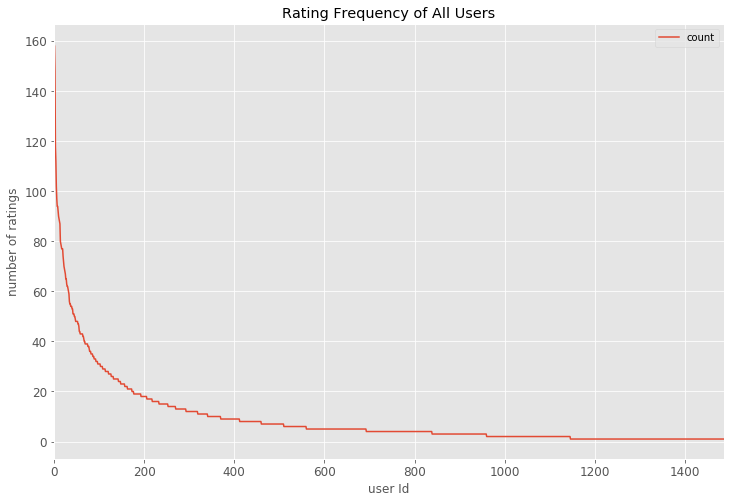

In [19]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings");

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    159.0
0.95     38.7
0.90     23.0
0.85     16.0
0.80     12.0
0.75      9.0
0.70      8.0
0.65      6.0
0.60      5.0
0.55      5.0
Name: count, dtype: float64

As expected, one can see that the distribution of ratings by users `id0` is very similar to the distribution of ratings among users `id1`. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating users that they evaluated. Vast majority of users aren't interested in rating others. So we can limit users to the top $40\%$.

In [21]:
# filter data
ratings_thres = 10
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_matches_drop_users_q = df_matches_drop_users[df_matches_drop_users.querying_user_id.isin(active_users)]
print('shape of original ratings data: ', df_matches.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_matches_drop_users_q.shape)

shape of original ratings data:  (18646, 15)
shape of ratings data after dropping both unpopular movies and inactive users:  (10260, 15)


## Train KNN model for item-based collaborative filtering

* Reshaping the Data
* Fitting model

#### 1. Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an (user0, X) array, where we have a user matrix, where each row is a collection of the user features.

We have to treat differently the different features according to their type.

First, we separately get a matrix $X_i$ for each different feature type $i$, hence we concatenate in a unique matrix $X$.

##### Texts

We make use of Tf-Idf vectoriser  for text features.

In [22]:
feature_text = list(df_types[df_types.type.isin(['text'])].variable)

In [23]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.05, max_features=250, ngram_range = (1,2), use_idf=True)

In [24]:
def getCorpus(str_series):
    """
        Function to convert a series (a dataframe column) of strings into a text corpus.
    """
    corpus = []
    for text in list(str_series):
        if(text):
            split = text.split()
            cleaned_string = [string for string in split if not re.findall('www.*|@.*|&|.*@.*|@|-|\||^#.*|.*\.com',string) and len(string) > 1]
            corpus.append(" ".join(cleaned_string))        
        else:
            corpus.append(" ")
            
    return corpus

In [25]:
X_texts_dict = {}
for feature in feature_text:
    corpus = getCorpus(df_users[feature])
    X = vectorizer.fit_transform(corpus)
    X_texts_dict[feature] = X

X_texts = list([x.toarray() for x in X_texts_dict.values()])

##### Categorical variables

In [26]:
feature_categories = list(df_types[df_types.type.isin(['category'])].variable)
feature_vect_categories = list(df_types[df_types.type.isin(['vector_category'])].variable)

In [27]:
for feature in feature_vect_categories:
    df_users[feature] = df_users[feature].fillna('')
    df_users[feature] = df_users[feature].apply(set)
    
for feature in feature_categories:
    df_users[feature] = df_users[feature].fillna('')

In [28]:
label_encoder = LabelEncoder()
multi_label_encoder = MultiLabelBinarizer()

In [29]:
X_cat_dict = {}
for feature in feature_categories:
    X_cat_dict[feature] = label_encoder.fit_transform(df_users[feature])
    
X_cat = list([x for x in X_cat_dict.values()])

In [30]:
X_vect_cat_dict = {}
for feature in feature_vect_categories:
    X_vect_cat_dict[feature] = multi_label_encoder.fit_transform(df_users[feature])
    
X_vect_cat = list([x for x in X_vect_cat_dict.values()])

##### Numerical Values

In [31]:
feature_numerical = list(df_types[df_types.type.isin(['numerical'])].variable)

In [32]:
X_num_dict = {}
for feature in feature_numerical:
    X_num_dict[feature] = np.array(df_users[feature])
    
X_num = list([x for x in X_num_dict.values()])

##### Creating the feature matrix

In [33]:
X_t = np.concatenate(X_texts, axis = 1)
X_c = np.column_stack(X_cat)
X_vc = np.concatenate(X_vect_cat, axis = 1)

In [34]:
print(X_t.shape)
print(X_c.shape)
print(X_vc.shape)

(2044, 149)
(2044, 2)
(2044, 314)


In [35]:
X = np.concatenate((X_t, X_c), axis = 1)
X = np.concatenate((X, X_vc), axis = 1)

In [36]:
X_norm = Normalizer().fit_transform(X)

#### 2. Fitting the model

Time to implement the model. 
We'll initialize the `NearestNeighbors` class as `model_knn` and fit our sparse matrix to the instance. By specifying the `metric = cosine`, the model will measure similarity bectween user vectors by using cosine similarity.

In [37]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(X_norm)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

##  Use this trained model to make recommendations

And we're finally ready to make some recommendations!

In [38]:
distances, indexes = model_knn.kneighbors(X_norm, n_neighbors=20)

## Supervised model

Until now we did not use the ratings given so far.
This because the model we trained is an unspurvised model.

The aim of this part of the notebook is to take advantage of the given matches to train a supervised model.

In [39]:
col_reduct = ['querying_user_id','recommended_user_id','match_ok']
df_matches = df_matches[col_reduct]

In [40]:
df_matches

,querying_user_id,recommended_user_id,match_ok
0,auth0|5c9251dd8493d55b61d62d57,auth0|5c814ef0a5d9e205f34bf54d,False
1,auth0|5cf6736040c0c00de7dec96d,auth0|5c5b21fdeb90374251db3614,True
2,auth0|5cf6736040c0c00de7dec96d,auth0|5c81568ba5d9e205f34bf7a5,True
3,auth0|5db2976b0cfca60dc2dbef3c,auth0|5c8684aadf09d10bf6e1499d,False
4,auth0|5be94d5b2134bd69842d1341,auth0|5c47159324e8262bce7be27a,True
...,...,...,...
18641,auth0|5a3945a322be3b22cd094659,auth0|5bd861a53b20cb0d1520bd84,True
18642,auth0|5c32a68c98e49d32424631b4,auth0|5c666b1bb569db2ad62fbbf0,False
18643,auth0|5c6d0534aeeba43360064d1f,auth0|5bf82585870e58394459162d,False
18644,auth0|5d8b8dd743634d0e103bdf05,auth0|5a3bdc88b5abfe59d4e7da43,False


What we would like to do is to create a so-called __utility matrix__ $\rho$ where each entry ($0$ or $1$) according to the match of the user in the row with the user in the column.

In [41]:
df_matches = df_matches[df_matches.querying_user_id.isin(df_users.auth0_id)]
df_matches = df_matches[df_matches.recommended_user_id.isin(df_users.auth0_id)]

`df_matches` is precisely the utility matrix we are looking for.

In [42]:
df_matches.reset_index(inplace=True, drop=True)
df_matches['match_ok'] = df_matches.match_ok.astype(int)

In [43]:
df_matches.pivot_table(index= 'querying_user_id', columns= 'recommended_user_id', values='match_ok')

recommended_user_id,auth0|5a376fa522be3b22cd07a59b,auth0|5a3770af22be3b22cd07a5ee,auth0|5a37727e150063783e1ff126,auth0|5a377330150063783e1ff174,auth0|5a3773df150063783e1ff1c4,auth0|5a37770a22be3b22cd07a809,auth0|5a377779150063783e1ff367,auth0|5a3778d1150063783e1ff407,auth0|5a3779ad150063783e1ff455,auth0|5a377a1b150063783e1ff486,...,auth0|5dd26ee33562480f235d34a2,auth0|5dd56b6b97ddd30f15d0054c,auth0|5dd56fc04e4cd60f17b36166,auth0|5dd6683c2d094f0f26098a9c,auth0|5dd7abd4d848730f14a34c6f,auth0|5ddbc49fdeb1a80f1fdf0d7a,auth0|5ddff99c3b76670ee048161f,auth0|5de1394289cefd0e156341eb,auth0|5de6483fa38eab0e21312cbf,auth0|5de681e069d4c40ef0f42dab
querying_user_id,,,,,,,,,,,,,,,,,,,,,
auth0|5a376fa522be3b22cd07a59b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5a376ff522be3b22cd07a5b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5a37703122be3b22cd07a5c6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5a3770af22be3b22cd07a5ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5a37727e150063783e1ff126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
auth0|5de0f660cf0f590e20209ae9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5de1394289cefd0e156341eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
auth0|5de533c989cefd0e156510eb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As one can see this is a very sparsed matrix.
To cope with such a set of data we need to implement an algorithm able to deal with matrix factorisation.
This is precisely what the __ALS__ (Alternating Least Square) algorithm does.

Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.
Some high-level ideas behind ALS are:
    
* Its objective function is slightly different than Funk SVD: ALS uses L2 regularization while Funk uses L1 regularization
        
* Its training routine is different: ALS minimizes two loss functions alternatively; It first holds user matrix fixed and runs gradient descent with item matrix; then it holds item matrix fixed and runs gradient descent with user matrix
    
* Its scalability: ALS runs its gradient descent in parallel across multiple partitions of the underlying training data from a cluster of machines
    
Just like other machine learning algorithms, ALS has its own set of hyper-parameters. We probably want to tune its hyper-parameters via some form of validation, _e.g._ __cross-validation__.

The most important hyper-parameters in Alternating Least Square (ALS) are the following.

1. `maxIter`: the maximum number of iterations to run (defaults to 10)
2. `rank`: the number of latent factors in the model (defaults to 10)
3. `regParam`: the regularization parameter in ALS (defaults to 1.0)

Hyper-parameter tuning is a highly recurring task in many machine learning projects. We can code it up in a function to speed up the tuning iterations.

Since __ALS__ is an algorithm working only in spark, we need to convert pandas dataframe to a spark one.

In [44]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc, countDistinct
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [45]:
# spark config
spark = SparkSession \
    .builder \
    .appName("Love recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

Exception: Java gateway process exited before sending its port number

In [ ]:
spark_profile = spark.read.json(profiles, multiLine=True)
spark_ratings = spark.read.load(matches, format='json', inferSchema=True)
#links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
#tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [ ]:
spark_ratings.select(['querying_user_id', 'recommended_user_id', 'match_ok']).show()

### Mapping ids to numbers

In [ ]:
q_user_list_rdd = spark_ratings.select('querying_user_id').rdd.map(list)
r_user_list_rdd = spark_ratings.select('recommended_user_id').rdd.map(list)

In [ ]:
spark_ratings.count()

In [ ]:
q_user_list = []
for id0 in q_user_list_rdd.take(spark_ratings.count()):
    q_user_list.append(id0[0])
    
r_user_list = []
for id0 in r_user_list_rdd.take(spark_ratings.count()):
    r_user_list.append(id0[0])
        
user_list = q_user_list + r_user_list

In [ ]:
# create unique list of  names
unique_ids = set(user_list)

# create mappings from names to id
name2id = {name: idx+1 for idx, name in enumerate(unique_ids)}

# map initial list of names to ids
user_ids = [name2id[name] for name in unique_ids]

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, user, match) tuples.

In [ ]:
spark_ratings_rdd = spark_ratings.select(['querying_user_id', 'recommended_user_id', 'match_ok']).rdd.map(tuple)

In [ ]:
def clean_match(match):
    if (match == 'false') or (match == 'False'):
        return False
    elif match == 'true' or (match == 'True'):
        return True
    else:
        return match

In [ ]:
matches_data = spark_ratings_rdd \
    .map(lambda x: (name2id[x[0]], name2id[x[1]], int(clean_match(x[2]))))\
    .cache()
# check three rows
matches_data.take(10)

In [ ]:
train, validation, test = matches_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache();

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    """
    grid search function to select the best model based on RMSE of
    validation data
    Parameters
    ----------
    train_data: spark DF with columns ['userId', 'userId', 'rating']
    
    validation_data: spark DF with columns ['userId', 'movieId', 'rating']
    
    maxIter: int, max number of learning iterations
    
    regParams: list of float, one dimension of hyper-param tuning grid
    
    ranks: list of float, one dimension of hyper-param tuning grid
    
    Return
    ------
    The best fitted ALS model with lowest RMSE score on validation data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = ALS(rank=rank, maxIter=maxIter, regParam=reg)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
# hyper-param config
num_iterations = 15
ranks = [8, 10, 12, 14, 16, 18, 20, 22, 25, 27, 29, 31]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

## ALS model learning curve

As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

This is precisely the aim of plotting a __Learning curve__.

In [ ]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

In [ ]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

The algorithm alternating gradient gradually descends to converge at an error around $0.42$.

## Model testing

And finally, make a prediction and check the testing error using out-of-sample data

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

In [ ]:
ratesAndPreds.take(3)

In [ ]:
test.take(3)